# Main Goals

In this chapter we will explore two ways of dealing with **overfitting**.
1. Polynomial Regression - Model Selection
2. Ploynomial Regression - Regularization

# Creating the Data

 We run the following code to create the data. This creates a synthetic dataset by adding some random Gaussian noise to a sinusoidal function. Note we used a specific seed so that the generated data would be identical in all runs.

No handles with labels found to put in legend.


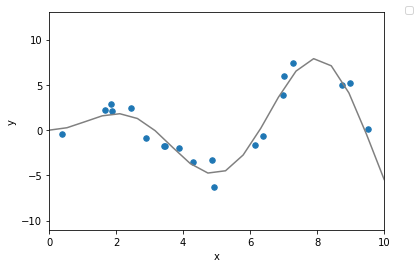

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

def f(x):
    return x * np.sin(x)

def plot_fit(ax, X_train=None, y_train=None, model=None, ploy_feat=None, label=None):
    min_x, max_x = np.floor(min(X_train)), np.ceil(max(X_train))
    x_range = np.linspace(min_x, max_x, len(X_train))
    y = f(x_range)
    min_y, max_y = np.floor(min(y))-5, np.ceil(max(y))+5
    ax.plot(x_range, y, color='gray')
    if X_train is not None and y_train is not None:
        ax.scatter(X_train, y_train, s=30)
    if model is not None:
        ax.plot(x_range, model.predict(ploy_feat.fit_transform(x_range)), label=label)
    ax.set_ylim((min_y, max_y))
    ax.set_xlim((min_x, max_x))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(bbox_to_anchor=(1.1, 1.05))

def create_data(n_samples = 100, test_size=0.8, min_x=0, max_x=10, err_scale=1):
    np.random.seed(9)
    X = np.random.uniform(min_x, max_x, size=n_samples)[:, np.newaxis]
    S = np.random.normal(loc=0, scale=err_scale, size=n_samples)[:, np.newaxis] # loc is mean, and scale is std
    y = f(X) + S
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
    return X, y, X_train, X_test, y_train, y_test

# generate data
X, y, X_train, X_test, y_train, y_test = create_data()
plot_fit(plt.gca(), X_train, y_train)

# Polynomial Regression - Model Selection

We apply polynomial regression to the data, using polynomials with maximal degree of 0 to 11.

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import operator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold , cross_val_score
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
def poly_features(deg, x):
    polynomial_features = PolynomialFeatures(degree=deg)
    x_poly = polynomial_features.fit_transform(x)
    return x_poly, polynomial_features

def linear_model(x_poly, y):
    model = LinearRegression()
    model.fit(x_poly, y)
    y_poly_pred = model.predict(x_poly)
    return y_poly_pred, model

def poly_coefficient(model):
    coeff = model.coef_
    coeff[0][0] = model.intercept_
    return coeff

# Visualizing the Polymonial Regression results
def plot_curves(x, y_poly_pred, deg):
    # sort the values of x before line plot
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
    x, y_poly_pred = zip(*sorted_zip)
    plt.plot(x, y_poly_pred, label='Degree: '+str(deg))
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    
# Print metrics
def results_metrics(y_true, y_pred):
    print('RMSE: ', np.sqrt(mean_squared_error(y_true,y_pred)))
    print('r2: ', r2_score(y_true,y_pred))

## Visualization degree 0 to 10

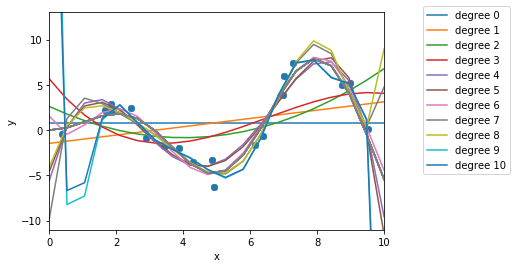

In [5]:
list_y_pred = []
for deg in range(11):
    X_poly, ploy_feat = poly_features(deg, X_train)
    y_pred , model= linear_model(X_poly, y_train)
    list_y_pred.append(y_pred)
    plot_fit(plt.gca(), X_train, y_train, model, ploy_feat, label='degree '+str(deg))


## Choose the best complexity

We choose the best degree of the polynome by plotting the errors from the train and the test set.

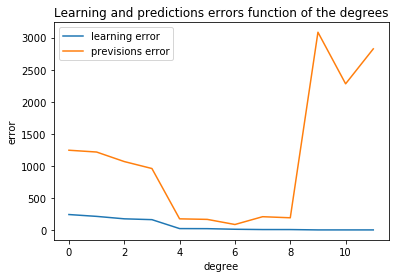

In [6]:
list_y_pred = []
err_learning = []
err_pred = []
for deg in range(12):
    X_poly, poly_feat = poly_features(deg, X_train)
    y_pred_train , model = linear_model(X_poly, y_train)
    
    #errors from train set
    err_learning.append(np.sum((y_train-y_pred_train)**2))
    
    #errors from test set
    y_pred_test = model.predict(poly_features(deg, X_test)[0])
    err_pred.append(np.sum((y_test-y_pred_test)**2))
    
plt.plot(err_learning, label='learning error')
plt.plot(err_pred, label='previsions error')
plt.title('Learning and predictions errors function of the degrees')
plt.xlabel('degree')
plt.ylabel('error')
plt.legend()
plt.show()

We see that the degree where the errors of prediction from the train and test set is the lowest, is the degree 6. So we can assume that our optimal degree is 6. Moreover, thanks to this graph we can see that the model strats to overfitting when the degree is upper than 8. And it underfits when the degree is less than 4.

## Apply k fold 

To optimize the model, we will use a cross validation method to find the optimal degree of the model. In fact, we see that degrees 5, 6 and 7 may be the optimal degree for the train and test sets.

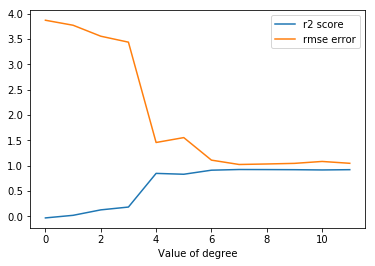

In [7]:
X, y, X_train, X_test, y_train, y_test = create_data()

kf = KFold(n_splits=5, random_state=42)

deg_list_r2 = []
deg_list_rmse = []

for deg in range(12):
    deg_r2_fold = []
    deg_rmse_fold = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        
        X_poly = poly_features(deg, X_train)[0]
        y_pred_train , model = linear_model(X_poly, y_train)
        y_pred_test = model.predict(poly_features(deg, X_test)[0])
                
        r2 = r2_score(y_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        
        deg_r2_fold.append(r2)
        deg_rmse_fold.append(rmse)
        
    deg_list_r2.append(np.mean(deg_r2_fold))
    deg_list_rmse.append(np.mean(deg_rmse_fold))

plt.plot(range(12), deg_list_r2, label='r2 score')
plt.plot(range(12), deg_list_rmse, label='rmse error')
plt.xlabel('Value of degree')
plt.legend()
plt.show()

We can see on the previous plot that the optimal degree is 7 because the rmse and the r2 start to converge at this point and reache their optimal values.

# Polynomial Regression - Regularization
Now, instead of choosing the best maximal degree to use, we will use polynomial regression with regularization. 

- Apply polynomial ridge regression with polynomial degree 11, using different regularization parameters (also test the case where the regularization parameter equals 0). For this task we should use L2-norm regularization (ridge regression), which uses the sum of squared parameters as the regularization term. That is, 
$$
L(\boldsymbol\theta) = \frac{1}{n}\sum_{i=0}^n (y_i – \boldsymbol\theta^T \mathbf{x}_i)^2 + \alpha \|\boldsymbol\theta\|_2
$$
where $\alpha$ is the regularization parameter, $\boldsymbol\theta$ is the vector of coefficients including the intercept term and $\mathbf{x}_i$ is the vector of the predictors of the i-th data point including a constant predictor for the intercept.

>Again, we plot the fitted polynomial against the trainning data and the underlying generating function. This time, we also plot the coefficients of the fitted polynomial. 

- What is the effect of applying regularization to the regression model, with different regularization parameters? What would be the best regularization parameter to use in this case? We compare our results with the model selection approach for overcoming the the problem of overfitting.

- We compare the above results with L1-norm regularization (LASSO) instead of the L2-norm, that is
$$
L(\boldsymbol\theta) = \frac{1}{n}\sum_{i=0}^n (y_i – \boldsymbol\theta^T \mathbf{x}_i)^2 + \alpha \|\boldsymbol\theta\|_1
$$

In [9]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import make_pipeline

## Ridge regularization 

In [8]:
def plot_curves_ridge(x, y_poly_pred, alpha):
    # sort the values of x before line plot
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
    x, y_poly_pred = zip(*sorted_zip)
    plt.plot(x, y_poly_pred, label='alpha: '+str(alpha))
    plt.legend(bbox_to_anchor=(1.1, 1.05))

In [10]:
def plot_fit(ax, X_train=None, y_train=None, model=None, label=None):
    min_x, max_x = np.floor(min(X_train)), np.ceil(max(X_train))
    x_range = np.linspace(min_x, max_x, len(X_train))
    y = f(x_range)
    min_y, max_y = np.floor(min(y))-5, np.ceil(max(y))+5
    ax.plot(x_range, y, color='gray')
    if X_train is not None and y_train is not None:
        ax.scatter(X_train, y_train, s=30)
    if model is not None:
        ax.plot(x_range, model.predict(x_range), label=label)
    ax.set_ylim((min_y, max_y))
    ax.set_xlim((min_x, max_x))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(bbox_to_anchor=(1.1, 1.05))

In [11]:
X, y, X_train, X_test, y_train, y_test = create_data()

For alpa:  0.0
Polynomial Coefficients:  [[ 6.3310e+01 -2.9474e+02  4.4300e+02 -3.2694e+02  1.3982e+02 -3.7620e+01
   6.6800e+00 -8.1000e-01  7.0000e-02 -0.0000e+00  0.0000e+00 -0.0000e+00]]


For alpa:  5.2631578947368425
Polynomial Coefficients:  [[ 0.83  0.27  0.37  0.24 -0.11 -0.28  0.23 -0.08  0.02 -0.    0.   -0.  ]]


For alpa:  10.526315789473685
Polynomial Coefficients:  [[ 1.14  0.16  0.22  0.14 -0.06 -0.16  0.13 -0.05  0.01 -0.    0.   -0.  ]]


For alpa:  15.789473684210527
Polynomial Coefficients:  [[ 1.27  0.11  0.15  0.1  -0.04 -0.11  0.09 -0.03  0.01 -0.    0.   -0.  ]]


For alpa:  21.05263157894737
Polynomial Coefficients:  [[ 1.34  0.09  0.12  0.08 -0.03 -0.09  0.07 -0.03  0.01 -0.    0.   -0.  ]]


For alpa:  26.315789473684212
Polynomial Coefficients:  [[ 1.38  0.07  0.1   0.07 -0.02 -0.07  0.05 -0.02  0.   -0.    0.   -0.  ]]


For alpa:  31.578947368421055
Polynomial Coefficients:  [[ 1.42  0.06  0.08  0.06 -0.02 -0.06  0.04 -0.02  0.   -0.    0.   -0.  ]]


For 

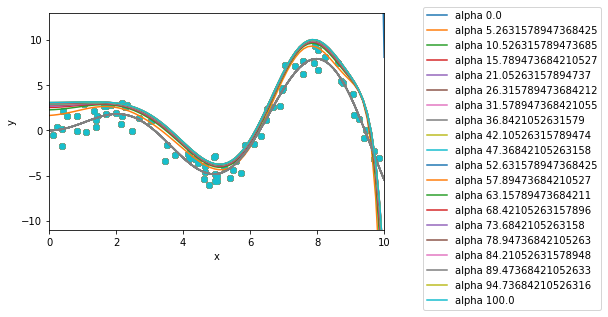

In [12]:
n_alphas = 20
alphas = np.linspace(0, 100, n_alphas)
r2_s = []
errors = []
for a in alphas:
    poly_feat = PolynomialFeatures(degree = 11)
    ridge = make_pipeline(poly_feat, Ridge(alpha=a))
    ridge.fit(X_train, y_train)
    
    y_pred_train = ridge.predict(X_train)
    y_pred_test = ridge.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    errors.append(rmse)  
    
    r2 = r2_score(y_train, y_pred_train)
    r2_s.append(r2)
    
    print('For alpa: ', str(a))
    print('Polynomial Coefficients: ', np.round(poly_coefficient(ridge.steps[1][1]), 2))
    print('\n')
    
#     plot_curves_ridge(X_train, y_pred_train, a)
    plot_fit(plt.gca(), X_test, y_test, ridge, label='alpha '+str(a))

#     plot_fit(plt.gca(), X_train, y_train=None, model=ridge, label=str(a))
# plt.scatter(X_train, y_train, color='red', s=10)
# plt.show()


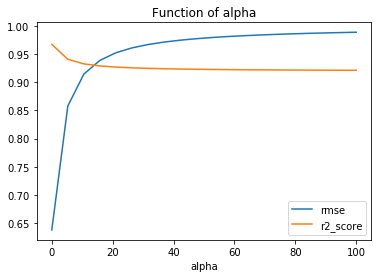

In [13]:
plt.plot(alphas, errors, label='rmse')
plt.plot(alphas, r2_s, label='r2_score')
plt.title('Function of alpha')
plt.xlabel('alpha')
plt.legend()
plt.show()

The ridge regularization is used to limit the instability due to variables too much correlated. Ridge decreases the euclidienne distances between solutions and converge to a global minimum.
The parameter alpha allows to tune the regularization. When it closes to zero the model looks like the same as before, when it tends to infinity (high value) so all coefficients of the model tend to zero.
When alpha is increasing, baias raises and the variance decreases.

However, on the train set we see clealy that the best model is the one with alpha equal to zero. In fact the model predicted elements which are the same during its training (he overfits). So the model is underfitting when the alpha raising up.

## Model selection on ridge

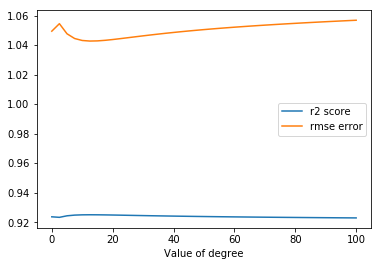

In [14]:
X, y, X_train, X_test, y_train, y_test = create_data()

n_alphas = 41
alphas = np.linspace(0, 100, n_alphas)

kf = KFold(n_splits=5, random_state=42)
a_list_r2 = []
a_list_rmse = []
for a in alphas:
    a_r2_fold = []
    a_rmse_fold = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        
        ridge = make_pipeline(PolynomialFeatures(degree = 11), Ridge(alpha=a))
        ridge.fit(X_train, y_train)
        y_pred_train = ridge.predict(X_train)
        y_pred_test = ridge.predict(X_test)
                
        r2 = r2_score(y_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        
        a_r2_fold.append(r2)
        a_rmse_fold.append(rmse)
        
    a_list_r2.append(np.mean(a_r2_fold))
    a_list_rmse.append(np.mean(a_rmse_fold))

plt.plot(alphas, a_list_r2, label='r2 score')
plt.plot(alphas, a_list_rmse, label='rmse error')
plt.xlabel('Value of degree')
plt.legend()
plt.show()

Here we see that with an alpha of 10, the r2 reaches its highest values and the rmse reaches is lowest value. So alpha = 10 is the optimal alpha.

## Lasso regularization

For alpa:  0.0
Polynomial Coefficients:  [[ 1.23  0.05  0.07  0.07  0.03 -0.02 -0.02  0.01 -0.    0.   -0.    0.  ]]


For alpa:  5.2631578947368425
Polynomial Coefficients:  [[ 1.23  0.05  0.07  0.07  0.03 -0.02 -0.02  0.01 -0.    0.   -0.    0.  ]]


For alpa:  10.526315789473685
Polynomial Coefficients:  [[ 1.23  0.05  0.07  0.07  0.03 -0.02 -0.02  0.01 -0.    0.   -0.    0.  ]]


For alpa:  15.789473684210527
Polynomial Coefficients:  [[ 1.23  0.05  0.07  0.07  0.03 -0.02 -0.02  0.01 -0.    0.   -0.    0.  ]]


For alpa:  21.05263157894737
Polynomial Coefficients:  [[ 1.23  0.05  0.07  0.07  0.03 -0.02 -0.02  0.01 -0.    0.   -0.    0.  ]]


For alpa:  26.315789473684212
Polynomial Coefficients:  [[ 1.23  0.05  0.07  0.07  0.03 -0.02 -0.02  0.01 -0.    0.   -0.    0.  ]]


For alpa:  31.578947368421055
Polynomial Coefficients:  [[ 1.23  0.05  0.07  0.07  0.03 -0.02 -0.02  0.01 -0.    0.   -0.    0.  ]]


For alpa:  36.8421052631579
Polynomial Coefficients:  [[ 1.23  0.05  0.07  0.0

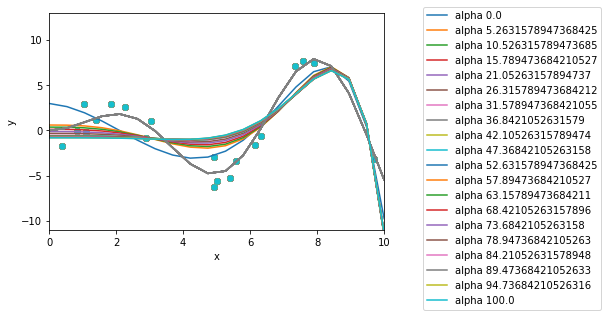

In [15]:
n_alphas = 20
alphas = np.linspace(0, 100, n_alphas)
r2_s = []
errors = []
for a in alphas:
    poly_feat = PolynomialFeatures(degree = 11)
    lasso = make_pipeline(poly_feat, Lasso(alpha=a))
    lasso.fit(X_train, y_train)
    
    y_pred_train = lasso.predict(X_train)
    y_pred_test = lasso.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    errors.append(rmse)  
    
    r2 = r2_score(y_train, y_pred_train)
    r2_s.append(r2)
    
    print('For alpa: ', str(a))
    print('Polynomial Coefficients: ', np.round(poly_coefficient(ridge.steps[1][1]), 2))
    print('\n')
    
#     plot_curves_ridge(X_train, y_pred_train, a)
    plot_fit(plt.gca(), X_test, y_test, lasso, label='alpha '+str(a))
# plt.scatter(X_train, y_train, color='red', s=10)
# plt.show()


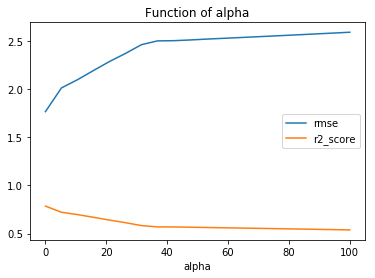

In [16]:
plt.plot(alphas, errors, label='rmse')
plt.plot(alphas, r2_s, label='r2_score')
plt.title('Function of alpha')
plt.xlabel('alpha')
plt.legend()
plt.show()

Once more, we see on the train set that the LASSO reduce the overfitting on the polynomial regression of degree 11.

We apply a cross validation to find the optimal value of alpha.

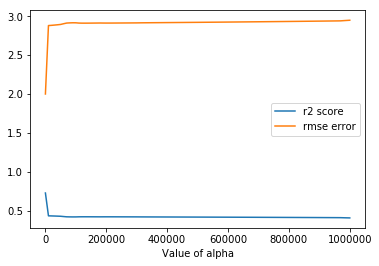

In [17]:
X, y, X_train, X_test, y_train, y_test = create_data()

n_alphas = 101
alphas = np.linspace(0, 1000000, n_alphas)

kf = KFold(n_splits=4, random_state=42)
a_list_r2 = []
a_list_rmse = []

for a in alphas:
    a_r2_fold = []
    a_rmse_fold = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        
        poly_feat = PolynomialFeatures(degree = 11)
        lasso = make_pipeline(poly_feat, Lasso(alpha=a))
        lasso.fit(X_train, y_train)
        
        y_pred_train = lasso.predict(X_train)
        y_pred_test = lasso.predict(X_test)
                
        r2 = r2_score(y_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        
        a_r2_fold.append(r2)
        a_rmse_fold.append(rmse)
        
        
    a_list_r2.append(np.mean(a_r2_fold))
    a_list_rmse.append(np.mean(a_rmse_fold))

plt.plot(alphas, a_list_r2, label='r2 score')
plt.plot(alphas, a_list_rmse, label='rmse error')
plt.xlabel('Value of alpha')
plt.legend()
plt.show()

Here we see that the best alpha is zero because the model of degree 11 is not enough overfitted (maximal value alpha put is 1000000).

I think that is due to the norme used in LASSO regularization. In fact, the Manathan distance is always longer than the euclidienne distance so its much harder for Lasso to put parameters at zero.